In [2]:
#first i need data from a previous run
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime
from scipy.optimize import curve_fit
import math
from scipy import asarray as ar,exp
import pylab as plb
import tqdm
from tqdm import tqdm
import time
import progressbar

In [5]:
dataset = np.load("/home/roberts/O-PPAC/recomplied_dataset.npy")
all_data = dataset[ : , :132]
all_labels = dataset[: , -2:]

print(all_data.shape)
print(all_labels.shape)

(338922, 132)
(338922, 2)


In [61]:
x_peaks = np.load("x_peaks_data_ALL.npy")
y_peaks = np.load("y_peaks_data_ALL.npy")
error_indices = np.load("error_indices.npy")

gaussian = np.vstack((x_peaks,y_peaks)) #define new, single variable for x and y gaussian peaks
gaussian = np.transpose(gaussian) #original definition was sideways, so we transposed it
print(gaussian.shape)

(318628, 2)


In [6]:
all_data = normalize(all_data,axis = 1)
print(np.max(all_data))

0.8395246220687987


In [85]:
#define all_labels and all_data as df's to better view rows and add column
all_labels = pd.DataFrame(all_labels)
all_data = pd.DataFrame(all_data)
all_data["sum"] = np.sum(all_data, axis = 1) #column added to find rows with only 0's
all_gauss = pd.DataFrame(gaussian)

#confirming number of initial entries
print(len(all_labels))
print(len(all_data))
print(len(all_gauss))
print(len(error_indices))


fixed_labels = all_labels.drop(all_labels.index[error_indices])
fixed_data = all_data.drop(all_data.index[error_indices])


#find all the locations in all_data (by index) where the only values are 0 across the diodes
remove_labels = list(fixed_data[fixed_data["sum"] == 0].index)
print(len(remove_labels))

#added these to ensure I have unshuffled versions of the data and labels for finding locations with larger error
unshuf_labels = fixed_labels.drop(fixed_labels.index[remove_labels])
unshuf_gauss = all_gauss.drop(all_gauss.index[remove_labels])
unshuf_data = fixed_data[fixed_data["sum"] != 0]

#lets all_labels and all_data start with the same indices and values as their unshuffled counterparts
all_labels = unshuf_labels
unshuf_labels = unshuf_labels.to_numpy() #dfs are hard to graph with, so I converted to np.arrays for future use
all_data = unshuf_data
unshuf_data = unshuf_data.to_numpy()
all_gauss = unshuf_gauss
unshuf_gauss = unshuf_gauss.to_numpy()

#confirm new number of entries (should be len(remove_labels) less than the intital value)
print(len(all_labels))
print(len(all_data))
print(len(all_gauss))

#must remove the sum column before using in FCNN; otherwise it will treat it as a data point 
del all_data['sum']

338922
338922
318628
20294
286
318342
318342
318342


In [88]:
type(all_gauss)
len(unshuf_gauss)

318342

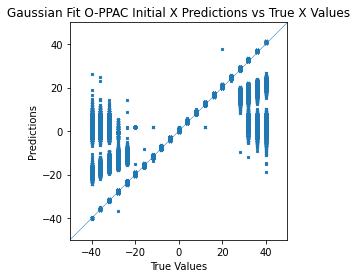

In [100]:
#graph showing intital accuracy of gaussian model by comparing predicted and true x values
#should be as close to the diagonal as possible
new_x_labels_g = []
for i in range(len(unshuf_gauss)):
    new_x_labels_g.append([unshuf_labels[i][0]])
np.array(new_x_labels_g)
new_x_labels_g[2]

a = plt.axes(aspect='equal')

plt.scatter(new_x_labels_g, unshuf_gauss[:,0], s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("Gaussian Fit O-PPAC Initial X Predictions vs True X Values")
plt.show()

In [98]:
train_data, test_data, train_labels, test_labels, train_gauss, test_gauss = train_test_split(all_data, all_labels, all_gauss, test_size=0.2,shuffle=False)
#splits training and test data for the FCNN; 20% set aside for testing

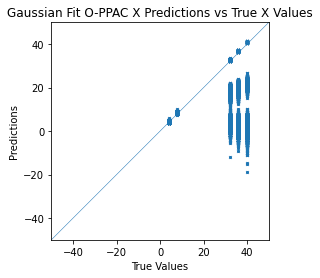

In [99]:
arr_test_gauss = test_gauss.to_numpy()
arr_test_labels = test_labels.to_numpy()
#graph showing intital accuracy of gaussian model by comparing predicted and true x values
#should be as close to the diagonal as possible
new_x_labels_g = []
for i in range(len(arr_test_gauss)):
    new_x_labels_g.append([arr_test_labels[i][0]])
np.array(new_x_labels_g)
new_x_labels_g[2]

a = plt.axes(aspect='equal')

plt.scatter(new_x_labels_g, arr_test_gauss[:,0], s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("Gaussian Fit O-PPAC X Predictions vs True X Values")
plt.show()

In [36]:
test_data.to_pickle("test_data_df_5")
test_labels.to_pickle("test_labels_df_5")

#df = pd.read_pickle(file_name)
#to read back in

In [37]:
#early stopping mechanism; can increase amount of time before stopping by increasing patience
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [38]:
#Fully connected neural network
#the "layers" are the dense hidden layers which are fully connected
#first number changes the nodes, 2nd is the activation function, (first line has number of inputs as well)

FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dropout(0.2))
FCNN_model.add(layers.Dense(2, activation = 'linear'))

In [39]:
#compiles the FCNN and includes the learning rate as well
FCNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [40]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=120,
                    batch_size = 32,
                    #callbacks = [callback],
                    validation_split = 0.3 
                    )

Epoch 1/120
5571/5571 [==============================] - 16s 3ms/step - loss: 4.0649 - mae: 0.6309 - mse: 4.0649 - val_loss: 663.4308 - val_mae: 17.4411 - val_mse: 663.4308
Epoch 2/120
5571/5571 [==============================] - 16s 3ms/step - loss: 0.4124 - mae: 0.3106 - mse: 0.4124 - val_loss: 850.2726 - val_mae: 19.7246 - val_mse: 850.2726
Epoch 3/120
5571/5571 [==============================] - 16s 3ms/step - loss: 0.3636 - mae: 0.2636 - mse: 0.3636 - val_loss: 897.1072 - val_mae: 20.1700 - val_mse: 897.1072
Epoch 4/120
5571/5571 [==============================] - 17s 3ms/step - loss: 0.3413 - mae: 0.2362 - mse: 0.3413 - val_loss: 933.9916 - val_mae: 20.4690 - val_mse: 933.9916
Epoch 5/120
5571/5571 [==============================] - 16s 3ms/step - loss: 0.3250 - mae: 0.2200 - mse: 0.3250 - val_loss: 934.4790 - val_mae: 20.7257 - val_mse: 934.4790
Epoch 6/120
5571/5571 [==============================] - 16s 3ms/step - loss: 0.3212 - mae: 0.2078 - mse: 0.3212 - val_loss: 894.3716 -

5571/5571 [==============================] - 16s 3ms/step - loss: 0.2439 - mae: 0.0822 - mse: 0.2439 - val_loss: 683.4521 - val_mae: 21.0662 - val_mse: 683.4521
Epoch 96/120
5571/5571 [==============================] - 17s 3ms/step - loss: 0.2430 - mae: 0.0823 - mse: 0.2430 - val_loss: 640.1239 - val_mae: 20.3766 - val_mse: 640.1239
Epoch 97/120
5571/5571 [==============================] - 17s 3ms/step - loss: 0.2453 - mae: 0.0826 - mse: 0.2453 - val_loss: 652.1282 - val_mae: 20.6696 - val_mse: 652.1282
Epoch 98/120
5571/5571 [==============================] - 16s 3ms/step - loss: 0.2428 - mae: 0.0819 - mse: 0.2428 - val_loss: 627.3530 - val_mae: 20.1672 - val_mse: 627.3530
Epoch 99/120
5571/5571 [==============================] - 16s 3ms/step - loss: 0.2419 - mae: 0.0815 - mse: 0.2419 - val_loss: 625.1970 - val_mae: 20.2237 - val_mse: 625.1970
Epoch 100/120
5571/5571 [==============================] - 17s 3ms/step - loss: 0.2443 - mae: 0.0814 - mse: 0.2443 - val_loss: 622.0127 - val_m

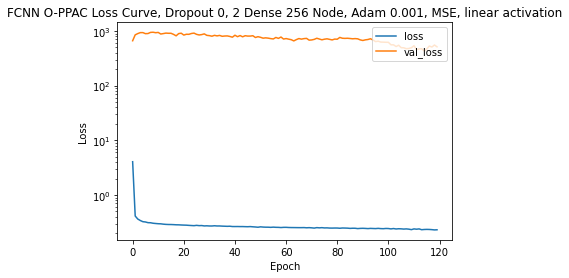

1990/1990 - 3s - loss: 1130.5287 - mae: 21.4157 - mse: 1130.5287


In [41]:
#loss plot of training and test data
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, Adam 0.001, MSE, linear activation")
plt.show()

#separation of 'result' values (stats from test data)
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

#separation of 'prediction' values (training data)
predictions = FCNN_model.predict(test_data)

In [66]:
#separates x and y predicted values so there can be separate graphs for each
x_pred = predictions[:,0]
y_pred = predictions[:,1]


x_test1 = test_labels[0]
y_test1 = test_labels[1]

#converts to np.arrays for graphing
x_test = np.array(x_test1)
y_test = np.array(y_test1)

x_test[0]
y_test[0]

0.0

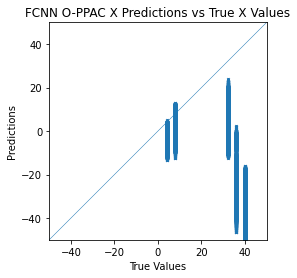

In [43]:
#graph showing the accuracy of FCNN model by comparing predicted and true x values
#should be as close to the diagonal as possible
new_x_labels = []
for i in range(x_test.shape[0]):
    new_x_labels.append([x_test[i]])
np.array(new_x_labels)
new_x_labels[2]

a = plt.axes(aspect='equal')

plt.scatter(new_x_labels, x_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC X Predictions vs True X Values")
plt.show()

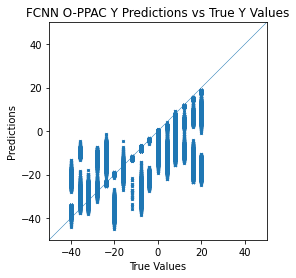

In [44]:
#graph showing the accuracy of FCNN model by comparing predicted and true y values
#should be as close to the diagonal as possible
new_y_labels = []
for i in range(y_test.shape[0]):
    new_y_labels.append([y_test[i]])
np.array(new_y_labels)
new_y_labels[2]

a = plt.axes(aspect='equal')
plt.scatter(new_y_labels, y_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC Y Predictions vs True Y Values")
plt.show()

In [45]:
#to find the locations of largest error within my predicted x values
x_error = []

#reads through every data point from the FCNN and compares to the true value by finding the difference between the two
for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

#this takes all the points with error greater than 1 mm
#one can then see the number of points with large error + use lower code to see where/what they are
xerror_list = [i for i in x_error if abs(i) >= 1]
xerror_list.sort(reverse = True)
print(len(xerror_list))
print(xerror_list)

59210
[4.746039390563965, 4.745325088500977, 4.555506706237793, 4.528082847595215, 4.513304710388184, 4.5018720626831055, 4.454934120178223, 4.453926086425781, 4.4284772872924805, 4.395740509033203, 4.385069847106934, 4.376975059509277, 4.33366584777832, 4.316230773925781, 4.312630653381348, 4.311652183532715, 4.2809906005859375, 4.27851676940918, 4.256328582763672, 4.236541748046875, 4.2295637130737305, 4.207096099853516, 4.184294700622559, 4.172356605529785, 4.154997825622559, 4.147832870483398, 4.1359663009643555, 4.128238677978516, 4.12429141998291, 4.123476982116699, 4.1215105056762695, 4.1208295822143555, 4.113980293273926, 4.10489559173584, 4.093335151672363, 4.081211090087891, 4.074085235595703, 4.059823989868164, 4.059014320373535, 4.055130958557129, 4.050820350646973, 4.047212600708008, 4.045269966125488, 4.042021751403809, 4.0414886474609375, 4.039088249206543, 4.037863731384277, 3.991426467895508, 3.9871463775634766, 3.984302520751953, 3.9834184646606445, 3.9797420501708984

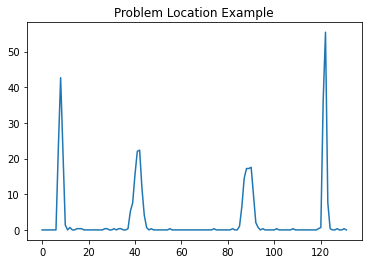

[337]


In [46]:
#graph the location of areas with larger x-error; uses unshuffled data from above
bad_xvalue = xerror_list[0]
x_test_locat = x_error.index(bad_xvalue)

plt.title('Problem Location Example')
plt.plot(unshuf_data[x_test_locat][:-1]*100)
plt.show()

#prints event index within histgrid
x_locat = np.where(x_pos == (np.array(x_test[x_error.index(bad_xvalue)])))
y_locat = np.where(y_pos == (np.array(y_test[x_error.index(bad_xvalue)])))

print(np.intersect1d(x_locat, y_locat))

In [47]:
#to find the locations of largest error within my predicted y values (same as the x code above but specific to y)
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

yerror_list = [i for i in y_error if abs(i) >= 1]
yerror_list.sort(reverse = True)
print(len(yerror_list))
print(yerror_list)

45953
[31.230586051940918, 30.949313163757324, 30.566080570220947, 30.3681697845459, 30.2562575340271, 30.183424472808838, 29.848248958587646, 29.73526620864868, 29.7094087600708, 29.42841386795044, 29.316930770874023, 29.2192645072937, 29.214479446411133, 29.193367958068848, 29.012134075164795, 28.89809226989746, 28.894289016723633, 28.89286231994629, 28.846049308776855, 28.812560081481934, 28.769306659698486, 28.767293453216553, 28.740989208221436, 28.730777740478516, 28.72454023361206, 28.67332124710083, 28.64690351486206, 28.606873989105225, 28.580825328826904, 28.555577754974365, 28.547995567321777, 28.547013759613037, 28.53485918045044, 28.53058099746704, 28.495463848114014, 28.494705200195312, 28.463497638702393, 28.462648391723633, 28.427271366119385, 28.418643951416016, 28.41717529296875, 28.38935375213623, 28.350987911224365, 28.33046579360962, 28.319557189941406, 28.31645679473877, 28.31354522705078, 28.2971830368042, 28.28218650817871, 28.261640071868896, 28.25916814804077,

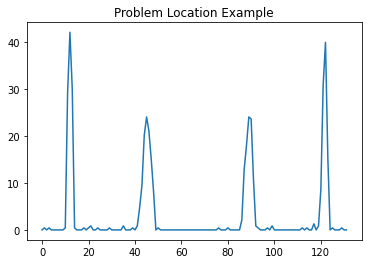

[284]


In [48]:
#graph the location of areas with larger error (bad_yvalue must come from y-prediction)
bad_yvalue = yerror_list[0]
y_test_locat = y_error.index(bad_yvalue)

plt.title('Problem Location Example')
plt.plot(unshuf_data[y_test_locat][:-1]*100)
plt.show()

#prints event index within histgrid
x_locat = np.where(x_pos == (np.array(x_test[y_error.index(bad_yvalue)])))
y_locat = np.where(y_pos == (np.array(y_test[y_error.index(bad_yvalue)])))

print(np.intersect1d(x_locat, y_locat))

24836


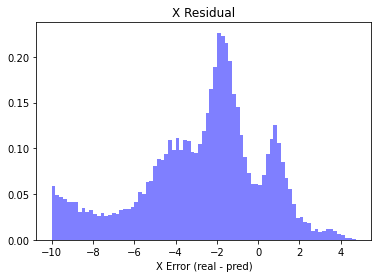

In [49]:
#residue plot of x-error from the FCNN model
x_error = []

for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

error_list_x = [i for i in x_error if abs(i) <= 10]
print(len(error_list_x))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_x, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('X Error (real - pred)')
plt.title(r'X Residual')
plt.show()

36955


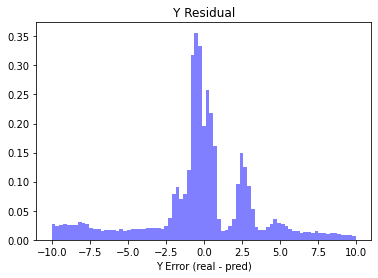

In [50]:
#residue plot of y-error from the FCNN model
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

error_list_y = [i for i in y_error if abs(i) <= 10]
print(len(error_list_y))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_y, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('Y Error (real - pred)')
plt.title(r'Y Residual')
plt.show()

In [51]:
#gaussian vs test labels

In [69]:
x_gauss_test = test_gauss[0]
y_gauss_test = test_gauss[1]

print(x_gauss_test.shape)
print(y_gauss_test.shape)

(63669,)
(63669,)


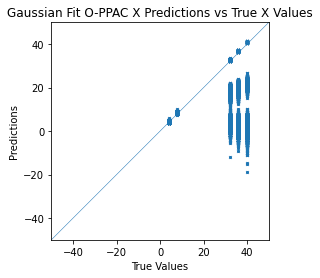

In [70]:
#graph showing the accuracy of FCNN model by comparing predicted and true x values
#should be as close to the diagonal as possible
new_x_labels = []
for i in range(x_test.shape[0]):
    new_x_labels.append([x_test[i]])
np.array(new_x_labels)
new_x_labels[2]

a = plt.axes(aspect='equal')

plt.scatter(new_x_labels, x_gauss_test, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("Gaussian Fit O-PPAC X Predictions vs True X Values")
plt.show()

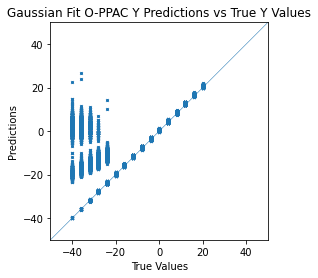

In [71]:
#graph showing the accuracy of FCNN model by comparing predicted and true x values
#should be as close to the diagonal as possible
new_y_labels_g = []
for i in range(y_test.shape[0]):
    new_y_labels_g.append([y_test[i]])
np.array(new_y_labels_g)
new_y_labels_g[2]

a = plt.axes(aspect='equal')

plt.scatter(new_y_labels_g, y_gauss_test, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("Gaussian Fit O-PPAC Y Predictions vs True Y Values")
plt.show()